import necessary libraries and datasets from [amirjarareh](https://github.com/amirjarareh/cnn_example) github

In [ ]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn import preprocessing

In [ ]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
%cd /content/
%rm -rf *
!git clone https://github.com/amirjarareh/cnn_example

%mv /content/cnn_example/* /content/
%rm -rf /content/cnn_example/
!unzip mnist_train.csv.zip
!unzip mnist_test.csv.zip
%rm /content/*.zip

/content
Cloning into 'cnn_example'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
Archive:  mnist_train.csv.zip
  inflating: mnist_train.csv         
Archive:  mnist_test.csv.zip
  inflating: mnist_test.csv          


# Mnist ANN

Mnist Dataset

In [ ]:
input_folder_path = "/content/"
train_df = pd.read_csv(input_folder_path+"mnist_train.csv")
test_df = pd.read_csv(input_folder_path+"mnist_test.csv")

In [ ]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_labels =  test_df['label'].values
test_images =  (test_df.iloc[:,1:].values).astype('float32')

In [ ]:
#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [ ]:
print(train_images.shape,val_images.shape,test_images.shape)

(48000, 28, 28) (12000, 28, 28) (10000, 28, 28)


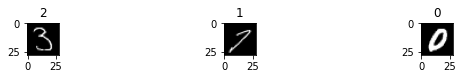

In [ ]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

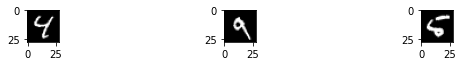

In [ ]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

In [ ]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

In [ ]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader =   DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader =  DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

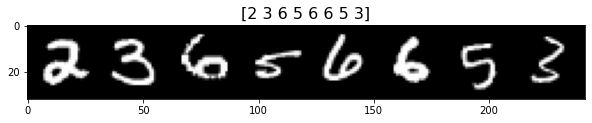

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

In [ ]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self,feature_size=28*28,output_size=10,seed=8):
        super(DeepNeuralNetwork, self).__init__()
        self.feature_size = feature_size
        self.output_size = output_size
        self.seed = seed
        
        self.linear_block = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.feature_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(64, self.output_size),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [ ]:
num_feature = 28*28
output_size = 10
ann_model = DeepNeuralNetwork(num_feature,output_size,8)
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

DeepNeuralNetwork(
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=2048, bias=True)
    (6): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=2048, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=512, out_features=256, bias=True)
    (

In [ ]:
optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

In [ ]:
def train_model(model,train_loader,num_epoch):
    model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
            
def evaluate(model,data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [ ]:
num_epochs = 1

for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    evaluate(ann_model, val_loader)

Train Epoch: 0 [1600/48000 (3%)]	Loss: 1.511058
Train Epoch: 0 [3200/48000 (7%)]	Loss: 0.994788
Train Epoch: 0 [4800/48000 (10%)]	Loss: 1.131911
Train Epoch: 0 [6400/48000 (13%)]	Loss: 1.509939
Train Epoch: 0 [8000/48000 (17%)]	Loss: 0.855386
Train Epoch: 0 [9600/48000 (20%)]	Loss: 0.372382
Train Epoch: 0 [11200/48000 (23%)]	Loss: 0.792515
Train Epoch: 0 [12800/48000 (27%)]	Loss: 0.921662
Train Epoch: 0 [14400/48000 (30%)]	Loss: 1.133776
Train Epoch: 0 [16000/48000 (33%)]	Loss: 1.604842
Train Epoch: 0 [17600/48000 (37%)]	Loss: 0.446220
Train Epoch: 0 [19200/48000 (40%)]	Loss: 1.140173
Train Epoch: 0 [20800/48000 (43%)]	Loss: 0.726823
Train Epoch: 0 [22400/48000 (47%)]	Loss: 1.027259
Train Epoch: 0 [24000/48000 (50%)]	Loss: 0.744673
Train Epoch: 0 [25600/48000 (53%)]	Loss: 0.795508
Train Epoch: 0 [27200/48000 (57%)]	Loss: 0.828005
Train Epoch: 0 [28800/48000 (60%)]	Loss: 0.618982
Train Epoch: 0 [30400/48000 (63%)]	Loss: 1.182788
Train Epoch: 0 [32000/48000 (67%)]	Loss: 1.036272
Train Ep

In [ ]:
def make_predictions(model,data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(ann_model,test_loader)

In [ ]:
# Make the confusion matrix
cmt = torch.zeros(10, 10, dtype=torch.int32)
for i in range(len(test_labels)):
    cmt[test_labels[i], test_set_preds[i]] += 1
cmt

tensor([[ 966,    0,    1,    1,    0,    2,    4,    2,    4,    0],
        [   0, 1115,    4,    1,    1,    0,    4,    0,   10,    0],
        [  16,    3,  950,    2,   16,    0,    6,   24,   13,    2],
        [   1,    3,   20,  939,    0,    3,    1,   12,   17,   14],
        [   2,    0,    3,    0,  841,    0,    7,    0,    5,  124],
        [  11,    4,    0,   54,    4,  762,    9,    3,   32,   13],
        [  18,    5,    1,    1,   11,    7,  902,    0,   13,    0],
        [   1,    9,   14,    2,    2,    0,    0,  940,    0,   60],
        [   9,    4,   10,    9,    4,    9,    1,    4,  898,   26],
        [   8,    7,    1,   10,    9,    0,    0,    3,   11,  960]],
       dtype=torch.int32)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, test_set_preds)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.92      0.93      1032
           3       0.92      0.93      0.93      1010
           4       0.95      0.86      0.90       982
           5       0.97      0.85      0.91       892
           6       0.97      0.94      0.95       958
           7       0.95      0.91      0.93      1028
           8       0.90      0.92      0.91       974
           9       0.80      0.95      0.87      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# Mnist CNN

Mnist Dataset

In [ ]:
input_folder_path = "/content/"
train_df = pd.read_csv(input_folder_path+"mnist_train.csv")
test_df = pd.read_csv(input_folder_path+"mnist_test.csv")

In [ ]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_labels =  test_df['label'].values
test_images =  (test_df.iloc[:,1:].values).astype('float32')

In [ ]:
#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [ ]:
print(train_images.shape,val_images.shape,test_images.shape)

(48000, 28, 28) (12000, 28, 28) (10000, 28, 28)


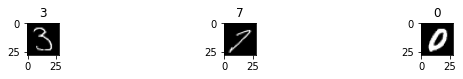

In [ ]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

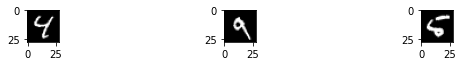

In [ ]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

In [ ]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

In [ ]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader =   DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader =  DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

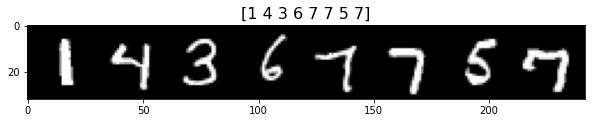

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

In [ ]:
class DeepNeuaralNetwork(nn.Module):
    def __init__(self,feature_size =28*28 ,output_size = 10,seed = 8):
        #initalization
        super(DeepNeuaralNetwork, self).__init__()

        self.feature_size = feature_size
        self.output_size = output_size
        self.seed = seed
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, self.output_size)
        )
        
    def forward(self, state):
        state = self.conv_block(state)
        state = state.view(state.size(0), -1)
        state = self.linear_block(state)
        
        return state

In [ ]:
conv_model = DeepNeuaralNetwork(output_size = 10)
if torch.cuda.is_available():
    conv_model = conv_model.cuda()
conv_model

DeepNeuaralNetwork(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [ ]:
def train_model(model,train_loader,num_epoch):
    model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
            
def evaluate(model,data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [ ]:
num_epochs = 3
for n in range(num_epochs):
    train_model(conv_model, train_loader, n)
    evaluate(conv_model, val_loader)

Train Epoch: 0 [1600/48000 (3%)]	Loss: 0.148965
Train Epoch: 0 [3200/48000 (7%)]	Loss: 0.244898
Train Epoch: 0 [4800/48000 (10%)]	Loss: 0.703377
Train Epoch: 0 [6400/48000 (13%)]	Loss: 0.109259
Train Epoch: 0 [8000/48000 (17%)]	Loss: 0.177308
Train Epoch: 0 [9600/48000 (20%)]	Loss: 0.283325
Train Epoch: 0 [11200/48000 (23%)]	Loss: 0.046272
Train Epoch: 0 [12800/48000 (27%)]	Loss: 0.096530
Train Epoch: 0 [14400/48000 (30%)]	Loss: 0.159679
Train Epoch: 0 [16000/48000 (33%)]	Loss: 0.101141
Train Epoch: 0 [17600/48000 (37%)]	Loss: 0.295932
Train Epoch: 0 [19200/48000 (40%)]	Loss: 0.368280
Train Epoch: 0 [20800/48000 (43%)]	Loss: 0.074174
Train Epoch: 0 [22400/48000 (47%)]	Loss: 0.199598
Train Epoch: 0 [24000/48000 (50%)]	Loss: 0.078071
Train Epoch: 0 [25600/48000 (53%)]	Loss: 0.104235
Train Epoch: 0 [27200/48000 (57%)]	Loss: 0.133706
Train Epoch: 0 [28800/48000 (60%)]	Loss: 0.174390
Train Epoch: 0 [30400/48000 (63%)]	Loss: 0.242767
Train Epoch: 0 [32000/48000 (67%)]	Loss: 0.024419
Train Ep

In [ ]:
def make_predictions(model,data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(conv_model,test_loader)

In [ ]:
# Make the confusion matrix
cmt = torch.zeros(10, 10, dtype=torch.int32)
for i in range(len(test_labels)):
    cmt[test_labels[i], test_set_preds[i]] += 1
cmt

tensor([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
        [   0, 1129,    3,    2,    0,    0,    0,    1,    0,    0],
        [   0,    0, 1029,    0,    0,    0,    0,    1,    2,    0],
        [   0,    0,    0, 1004,    0,    1,    0,    2,    3,    0],
        [   0,    0,    2,    0,  966,    0,    5,    0,    4,    5],
        [   0,    0,    0,    6,    0,  880,    2,    0,    1,    3],
        [   4,    3,    0,    0,    1,    1,  948,    0,    1,    0],
        [   0,    2,   17,    1,    1,    0,    0, 1005,    0,    2],
        [   1,    0,    2,    2,    0,    0,    0,    0,  968,    1],
        [   1,    0,    1,    0,    2,    2,    0,    2,   10,  991]],
       dtype=torch.int32)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, test_set_preds)

print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.98      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Turkije Acoustic ANN

In [ ]:
data = pd.read_csv("/content/HW2_Acoustic Features.csv")
data

,Class,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,...,_Chromagram_Mean_9,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunction_PeriodEntropy
0,relax,0.052,0.591,9.136,130.043,3.997,0.363,0.887,0.078,0.221,...,0.426,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.970
1,relax,0.125,0.439,6.680,142.240,4.058,0.516,0.785,0.397,0.556,...,0.002,1.000,0.000,0.984,0.285,0.211,-0.082,3.364,0.702,0.967
2,relax,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,...,0.184,0.746,0.016,1.000,0.413,0.299,0.134,1.682,0.692,0.963
3,relax,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,...,0.038,1.000,0.161,0.757,0.422,0.265,0.042,0.354,0.743,0.968
4,relax,0.066,0.591,9.769,88.890,3.217,0.228,0.814,0.096,0.434,...,0.004,0.404,1.000,0.001,0.345,0.261,0.089,0.748,0.674,0.957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,angry,0.174,0.578,5.265,161.144,2.985,0.065,0.718,0.046,0.265,...,0.374,0.838,0.413,0.125,0.323,0.140,0.120,2.691,0.867,0.969
396,angry,0.176,0.498,5.042,179.787,2.790,-0.148,0.342,-0.011,0.029,...,0.020,1.000,0.640,0.010,0.233,0.127,0.145,3.364,0.879,0.967
397,angry,0.187,0.557,4.724,134.032,1.672,0.566,0.880,-0.113,0.244,...,0.052,0.184,0.287,0.101,0.269,0.157,0.111,3.364,0.819,0.962
398,angry,0.140,0.573,4.470,113.600,1.997,-0.210,0.694,0.089,0.206,...,0.137,1.000,0.304,0.140,0.277,0.144,0.061,3.364,0.811,0.969


In [ ]:
# split data & label
X_train = data.iloc[:, 1:].values.astype(np.float32)
Y_train = data.iloc[:, 0].values

data_classes = ['relax', 'happy', 'sad', 'angry']
d = dict(zip(data_classes, range(0,4)))
Y_train = data.iloc[:, 0].map(d, na_action='ignore').values
# Y_train = preprocessing.scale(Y_train)

# make Train & validation set
train_set, test_set, train_labels, test_labels = train_test_split(X_train, Y_train, stratify=Y_train,
                                                                      random_state= 231,test_size=0.20)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, stratify=train_labels,
                                                                      random_state= 312,test_size=0.10)

In [ ]:
print(train_set.shape,val_set.shape,test_set.shape)
print(train_labels.shape,val_labels.shape,test_labels.shape)

(288, 50) (32, 50) (80, 50)
(288,) (32,) (80,)


In [ ]:
# preproccess data
train_set = preprocessing.scale(train_set)
val_set = preprocessing.scale(val_set)
test_set = preprocessing.scale(test_set)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably v

In [ ]:
#train
train_data_tensor = torch.tensor(train_set)
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_data_tensor, train_labels_tensor)
print(train_data_tensor.shape)
#val
val_data_tensor = torch.tensor(val_set)
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_data_tensor, val_labels_tensor)
#test
test_data_tensor = torch.tensor(test_set)

torch.Size([288, 50])


In [ ]:
# prepare dataset for torch
train_set_tensor = torch.tensor(train_set)
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_set_tensor, train_labels_tensor)
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)

val_set_tensor = torch.tensor(val_set)
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_set_tensor, val_labels_tensor)
val_loader =   DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)

test_set_tensor = torch.tensor(test_set)
test_labels_tensor = torch.tensor(test_labels)
test_tensor = TensorDataset(test_set_tensor, test_labels_tensor)
test_loader = DataLoader(test_tensor, batch_size=16, num_workers=2, shuffle=False)

In [ ]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self,num_feature = 50,output_size = 4,seed = 8):
        super(DeepNeuralNetwork, self).__init__()

        self.num_feature = num_feature
        self.output_size = output_size
        self.seed = seed

        
        self.linear_block = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.num_feature, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(32, self.output_size)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [ ]:
ann_model = DeepNeuralNetwork(num_feature = 50,output_size = 4,seed = 8)
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

DeepNeuralNetwork(
  (linear_block): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=50, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=128, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.2, inplace=False)
    (17): Linear(in_features=256, out_features=128, bias=True)
    (18): Batch

In [ ]:
optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

In [ ]:
def train_model(model,train_loader,num_epoch):
    model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
            
def evaluate(model,data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [ ]:
num_epochs = 10

for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    evaluate(ann_model, val_loader)


Average Val Loss: 0.8624, Val Accuracy: 21/32 (65.625%)


Average Val Loss: 0.6956, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 0.4741, Val Accuracy: 27/32 (84.375%)


Average Val Loss: 0.6355, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.6029, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.4470, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.4437, Val Accuracy: 27/32 (84.375%)


Average Val Loss: 0.4320, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.4054, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4380, Val Accuracy: 29/32 (90.625%)



In [ ]:
def make_predictions(model,data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, (data, target) in enumerate(data_loader):
      
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(ann_model,test_loader)

In [ ]:
# Make the confusion matrix
cmt = torch.zeros(4, 4, dtype=torch.int32)
for i in range(len(test_labels)):
    cmt[test_labels[i], test_set_preds[i]] += 1
cmt

tensor([[16,  0,  4,  0],
        [ 0, 20,  0,  0],
        [ 1,  5, 13,  1],
        [ 0,  0,  5, 15]], dtype=torch.int32)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

report = classification_report(test_labels, test_set_preds)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.80      1.00      0.89        20
           2       0.59      0.65      0.62        20
           3       0.94      0.75      0.83        20

    accuracy                           0.80        80
   macro avg       0.82      0.80      0.80        80
weighted avg       0.82      0.80      0.80        80

